In [1]:
from imprint.nb_util import setup_nb

setup_nb()

import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt

import imprint as ip
from imprint.models.fisher_exact import FisherExact, BoschlooExact

jax.config.update("jax_enable_x64", True)

## Fisher Exact is conservative

Why?
1. The Fisher exact test is used for discrete data so it might not be possible to achieve precisely 5% Type I Error. 
2. Fisher exact conditions on the number of success and failures in each arm of the trial being fixed. In the parlance of 2x2 contigency tables, it conditions on both the row and column marginals. But, we only have fixed row marginals.

Let's examine the worst case Type I Error for Fisher exact when applied to experimental trial data. These data do follow the fixed row marginal assumption because the number of patients in an arm of the trial is fixed. But, the data violate the fixed column marginal assumption because the total number of successes and failures is definitely not fixed. So we should expect Fisher exact to be quite conservative. We set `lam = 0.05`, meaning that we are targeting a 5% Type I Error. And indeed, the worst case Type I Error is less than 3% for all arm sizes except 12. We're leaving a lot of power on the table!

In [2]:
K = 4096
lam = 0.05
gs = {}
fisher_dfs = {}
for n in range(3, 15):
    print(n, end=", ")
    gs[n] = ip.cartesian_grid(
        [-3, -3], [3, 3], n=[20, 20], null_hypos=[ip.hypo("theta1 < theta0")]
    )
    fisher_dfs[n] = ip.validate(FisherExact, gs[n], lam, K=K, model_kwargs=dict(n=n))
    print(f"n={n} max(error_fisher)={fisher_dfs[n]['tie_est'].max()}")

3, n=3 max(error_fisher)=0.0
4, n=4 max(error_fisher)=0.00439453125
5, n=5 max(error_fisher)=0.009521484375
6, n=6 max(error_fisher)=0.02099609375
7, n=7 max(error_fisher)=0.013671875
8, n=8 max(error_fisher)=0.017822265625
9, n=9 max(error_fisher)=0.017333984375
10, n=10 max(error_fisher)=0.023681640625
11, n=11 max(error_fisher)=0.029541015625
12, n=12 max(error_fisher)=0.035888671875
13, n=13 max(error_fisher)=0.026611328125
14, n=14 max(error_fisher)=0.026611328125


## For experimental trial data, Boschloo is ideal

The [Boschloo exact test](https://en.wikipedia.org/wiki/Boschloo%27s_test) is ideal for our situation because it only assumes fixed row marginals.

We'd like to compare these Type I Error numbers against the Boschloo Exact test. But, to do that using `imprint`, we need to run lots of simulations. That's tough when the scipy implementation of Boschloo is very slow! Doing 400 simulations takes about one second.

In [3]:
%%time
sim_direct = BoschlooExact(0, 400, n=10).sim_batch(
    0, 400, jnp.array([[0.0, 0.0]]), jnp.array([[True, True]])
)

CPU times: user 2.62 s, sys: 15.2 ms, total: 2.63 s
Wall time: 2.81 s


The Fisher analysis above required 20^2 * 4096 = 1.6 million simulations. At 400 simulations per second, we would need to simulate for over an hour. That's not too bad overall but there's a lot of room for improvement. This is a great situation to demonstrate one common technique for optimizing a discrete model: lookup tables.

The number of possible datasets with two arms drawn from a Binomial with N = 10 is (10 + 1)^2 == 121. So, we can precompute the test statistic for each of those 121 datasets and then lookup from that table to simulate.

Below, we create lookup tables for both Boschloo exact and Fisher exact.

In [4]:
def contingency_lookup(n, f):
    successes = np.stack(np.meshgrid(np.arange(n + 1), np.arange(n + 1)), axis=-1)
    successes_flat = successes.reshape(-1, 2)
    possible_datasets = np.concatenate(
        (successes_flat[:, None, :], n - successes_flat[:, None, :]),
        axis=1,
    )
    return np.array(
        [f(possible_datasets[i]) for i in range(possible_datasets.shape[0])]
    )


def boschloo_table(n):
    f = lambda x: scipy.stats.boschloo_exact(x, alternative="less").pvalue
    return contingency_lookup(n, f)


def fisher_table(n):
    f = lambda x: scipy.stats.fisher_exact(x, alternative="less")[1]
    return contingency_lookup(n, f)

And here is an Imprint model that uses one of these lookup tables.

In [5]:
@jax.jit
def _sim_jax(table, samples, theta, null_truth):
    n = samples.shape[1]
    p = jax.scipy.special.expit(theta)
    successes = jnp.sum(samples[None, :] < p[:, None, None], axis=2)
    return table[successes[..., 1] * (n + 1) + successes[..., 0]]


class ContingencyLookup:
    def __init__(self, seed, max_K, *, n, table_builder):
        self.family = "binomial"
        self.family_params = {"n": n}
        self.samples = jax.random.uniform(
            jax.random.PRNGKey(seed), shape=(max_K, n, 2), dtype=jnp.float32
        )
        self.table = table_builder(n)

    def sim_batch(self, begin_sim, end_sim, theta, null_truth, detailed=False):
        return _sim_jax(self.table, self.samples[begin_sim:end_sim], theta, null_truth)

Let's check that the results are the same as when we simulated directly.

In [6]:
sim_lookup = ContingencyLookup(0, 400, n=10, table_builder=boschloo_table).sim_batch(
    0, 400, jnp.array([[0.0, 0.0]]), jnp.array([[True, True]])
)
sim_direct - sim_lookup

DeviceArray([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0.

Since our simulation is quite simple, we could optimize even more by integrating the lookup table against the 2D joint Binomial PMF. 

Now, we run the same loop over different N values as above. There are two important things to notice here:
1. The Type I Error is much closer to the requested 5% than for Fisher.
2. There are a couple values of `n` for which the maximum Type I Error is greater than 5%. This is a result of slack in the bound. With more simulations and smaller tiles, this slack would decrease to zero and we would be able to confirm that the Type I Error is indeed less than 5%.

In [7]:
boschloo_dfs = {}
for n in range(3, 15):
    print(n, end=", ")
    gs[n] = ip.cartesian_grid(
        [-3, -3], [3, 3], n=[20, 20], null_hypos=[ip.hypo("theta1 < theta0")]
    )
    boschloo_dfs[n] = ip.validate(
        ContingencyLookup,
        gs[n],
        lam,
        K=K,
        model_kwargs=dict(n=n, table_builder=boschloo_table),
    )
    print(f"n={n} max(boschloo)={boschloo_dfs[n]['tie_est'].max()}")

3, n=3 max(boschloo)=0.016357421875
4, n=4 max(boschloo)=0.03564453125
5, n=5 max(boschloo)=0.03125
6, n=6 max(boschloo)=0.033203125
7, n=7 max(boschloo)=0.0400390625
8, n=8 max(boschloo)=0.05029296875
9, n=9 max(boschloo)=0.048583984375
10, n=10 max(boschloo)=0.048828125
11, n=11 max(boschloo)=0.05224609375
12, n=12 max(boschloo)=0.0498046875
13, n=13 max(boschloo)=0.041259765625
14, n=14 max(boschloo)=0.04833984375


## Calibrated Fisher is Boschloo!

In the previous sections, we've used Imprint's validation tools. The basic output of validation is a probabilistic upper confidence bound on Type I Error. This is useful, but does not give rigorous control over Type I Error because there's still a small probability of that confidence interval being violated.

Calibration is an alternative error control mechanism where we can calibrate the rejection threshold in a way that we can provide rigorous Type I Error control. For details, see our paper.

The $\lambda^{**}$ in an Imprint calibration procedure is equivalent to the $\alpha^*$ in one definition of Boschloo's test!

<img width=800 src="2022-12-19-19-04-00.png" />

In [8]:
n = 10
alpha = 0.05
W = 0.25
g = ip.cartesian_grid(
    [-W, -W], [W, W], n=[32, 32], null_hypos=[ip.hypo("theta1 < theta0")]
)
cal_df = ip.calibrate(
    ContingencyLookup,
    g=g,
    alpha=alpha,
    K=2**17,
    model_kwargs=dict(n=n, table_builder=fisher_table),
)

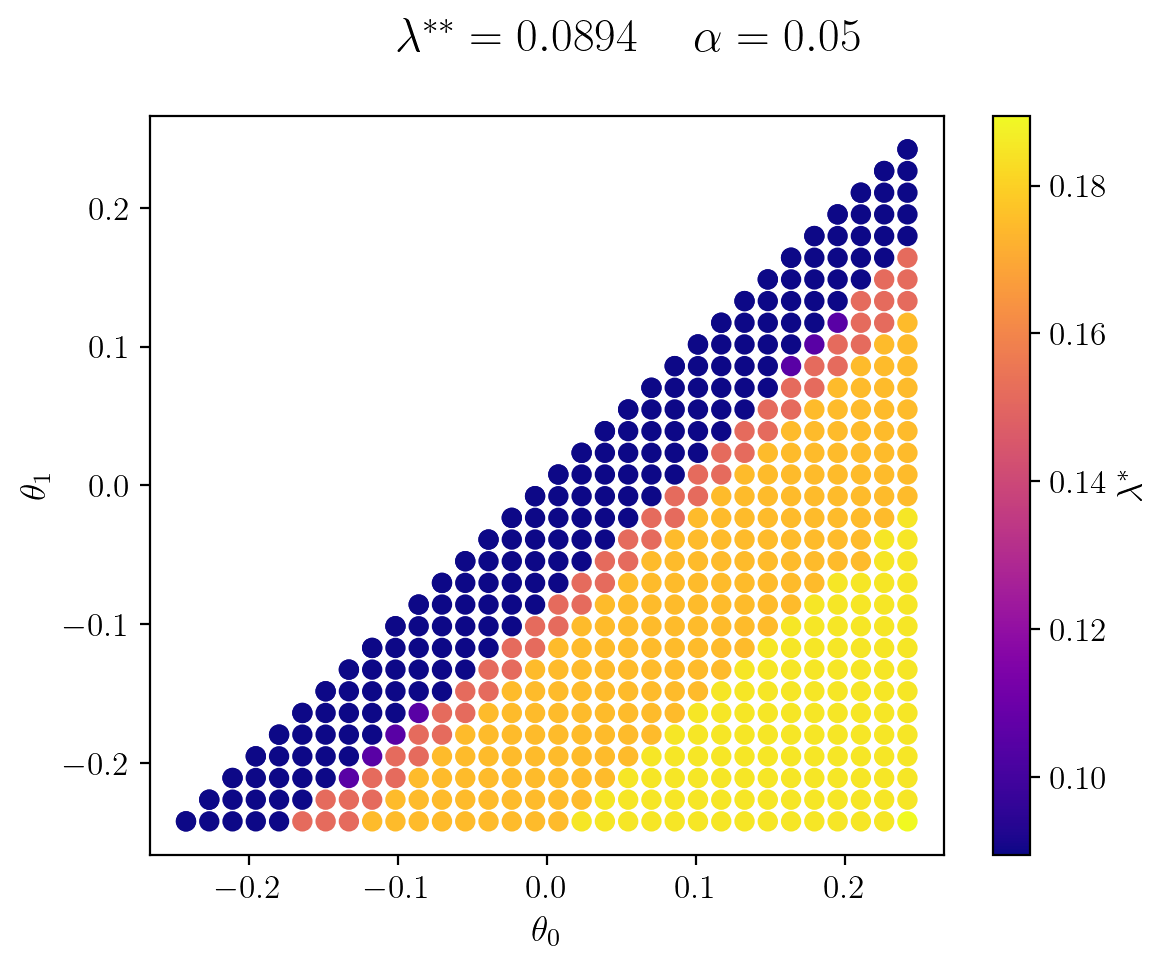

In [9]:
lamss = cal_df["lams"].min()
plt.suptitle("$\lambda^{**} = " + f"{lamss:.4f} ~~~~ \\alpha = {alpha}$")
plt.scatter(
    g.df["theta0"], g.df["theta1"], c=cal_df["lams"], s=40, vmin=lamss, vmax=lamss + 0.1
)
plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$")
plt.colorbar(label="$\lambda^*$")
plt.show()

As expected, if we look at the rejection decision for each entry in the two lookup tables, there are no differences. The decisions are identical. A calibrated Fisher exact test is exactly Boschloo's exact test.

In [10]:
boschloo = boschloo_table(n)
tuned_fisher = fisher_table(n)
differences = np.where(((boschloo < lam) != (tuned_fisher < lamss)))[0]
differences

array([], dtype=int64)